<a href="https://colab.research.google.com/github/danielchang2002/FecalMetabolomics/blob/main/FecalMetabolomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load Data**##

In [102]:
import os
cwd = os.getcwd()

In [103]:
import pandas as pd

# read excel spreadsheet into a dataframe
raw = pd.read_excel(cwd + '/MAYO-01-17VW Client Data Tables and Stats Mouse Feces.xlsx', header=None, sheet_name=2, usecols="B, N:W", skiprows=lambda x: x in [0, 1, 2, 3, 4, 6])
raw.head()

,1,13,14,15,16,17,18,19,20,21,22
0,NaN,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12
1,(12 or 13)-methylmyristate (a15:0 or i15:0),0.546,1.7082,0.8329,0.8805,0.8143,1.5794,1.5593,0.76,1.1195,1.1442
2,(14 or 15)-methylpalmitate (a17:0 or i17:0),0.8032,1.0926,0.985,1.015,1.5243,1.3033,1.1455,0.8295,0.9563,0.9599
3,(16 or 17)-methylstearate (a19:0 or i19:0),0.8984,0.9141,0.8902,1.3977,1.8192,1.4932,1.4213,0.8549,0.8502,1.0859
4,(3'-5')-adenylyladenosine*,0.9026,0.3172,0.3172,0.3172,1.1893,1.834,1.0974,0.3172,0.8672,0.3172


In [104]:
def clean(df):
  """
  Processes the raw excel spreadsheet dataframe with pandas. Returns cleaned dataframe
  """
  # tranpose so axis 0 is the example dimension and axis 1 is the features dimension
  transposed = df.transpose()
  transposed.reset_index(drop=True, inplace=True)

  # use first row as header
  # https://stackoverflow.com/a/31328974/14772896
  new_header = transposed.iloc[0] #grab the first row for the header
  transposed = transposed[1:] #take the data less the header row
  transposed.columns = new_header #set the header row as the df header
  transposed.reset_index(drop=True, inplace=True)

  # Make a target column based on whether or not the sample was taken in Week 12
  transposed.insert(0, 'AfterProbiotic', transposed.iloc[:, 0] == 'Week 12', allow_duplicates=False)
  transposed = transposed.loc[:, transposed.columns.notnull()]
  transposed.index.name = None
  return transposed.apply(pd.to_numeric)

In [105]:
from sklearn.preprocessing import StandardScaler

def standardize(df):
  """
  Returns a scaled version of df
  """
  scaler = StandardScaler() 
  scaled_df = scaler.fit_transform(df) 
  
  # Converting the numpy array into a pandas DataFrame 
  return pd.DataFrame(scaled_df) 


In [106]:
cleaned = clean(raw)
cleaned.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,False,0.5460,0.8032,0.8984,0.9026,0.5895,0.7820,0.6664,0.5189,0.9074,1.2116,0.5427,0.6067,0.7175,0.7145,4.6615,1.6053,1.6341,4.6839,0.2503,3.9389,2.0097,3.4388,2.3607,1.4496,1.7480,1.9858,1.5399,1.3928,2.6434,2.3116,3.2434,4.1724,4.1408,1.4611,1.3410,1.5991,0.9461,0.9943,0.6965,...,1.1918,1.6236,1.7702,1.2727,0.8276,1.9298,0.6983,0.2856,1.2941,2.0689,1.1117,3.8552,1.1622,1.2221,0.6737,2.0233,2.5518,0.3663,1.4431,0.6906,1.0781,0.7372,0.8385,0.8229,1.4471,1.4708,0.4072,0.8448,0.7833,1.8113,1.3575,1.3563,1.5313,1.0474,1.5043,1.5338,0.8068,0.9834,2.4123,1.4753
1,True,1.7082,1.0926,0.9141,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,0.6040,1.0262,0.4663,1.0000,1.0000,0.2503,1.0040,0.6730,0.6585,0.6235,1.1078,2.2458,1.2141,0.4362,0.0858,0.7279,1.1054,1.0840,1.0007,0.8398,1.0126,0.9336,0.7017,0.8449,1.4152,1.1351,...,0.2109,0.8326,0.4171,0.9422,1.7185,0.2752,0.7347,1.8993,0.8684,0.1221,0.9027,0.6520,0.2147,0.4120,1.2166,0.6022,0.3181,0.4783,0.7314,2.9701,0.4673,1.1139,0.9261,0.3800,0.0017,0.2868,0.1893,2.1602,0.7758,0.2236,0.6053,0.2418,0.3690,0.3287,0.4077,0.3621,1.0022,0.1372,0.7363,1.1754
2,False,0.8329,0.9850,0.8902,0.3172,0.5895,0.3336,0.3080,0.5189,0.5163,0.4368,0.5427,0.2938,0.4669,0.7560,2.3316,1.5337,0.8185,1.6029,0.2503,2.5860,0.9050,2.6298,1.1685,0.8655,0.8705,0.9987,1.0549,0.1557,1.3904,2.2538,2.6043,1.7533,1.9176,1.2990,0.9681,0.5809,0.5752,1.0057,0.9343,...,0.4894,1.0996,0.7747,1.0566,1.1663,1.2115,0.4887,0.3311,1.4079,1.0057,0.7584,3.3192,0.4822,0.5202,0.3360,1.0181,0.8959,0.1219,1.0160,0.6844,0.7175,0.9009,1.0247,0.5208,0.0017,1.0049,0.3182,1.0000,2.6314,0.7570,1.0206,0.6120,1.0378,0.6646,0.6428,0.8183,1.0019,0.6681,1.0300,1.3615
3,True,0.8805,1.0150,1.3977,0.3172,0.5895,0.3336,0.3080,0.5189,0.2363,0.2442,0.5427,0.2938,0.4669,1.3395,0.8934,0.4233,0.4953,0.4717,4.9623,0.5483,10.1152,0.3349,0.6235,2.2668,0.5827,2.1054,0.3546,0.0858,0.6017,0.6093,0.6119,0.7667

In [107]:
X = standardize(cleaned.iloc[:, 1:])
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822
0,-1.447063,-1.244542,-0.808721,0.312265,-0.601605,0.066305,-0.086694,-0.333333,-0.080018,0.693562,-0.442248,-0.183238,-0.305665,-1.082029,2.666472,2.076368,2.222676,2.853727,-0.441350,2.459273,-0.016601,2.215608,2.844037,0.511951,1.251212,1.349705,1.263083,0.142102,2.648302,1.664084,2.250878,2.765169,2.338826,1.638219,0.601468,-0.304702,-0.361249,0.124719,-1.316680,0.238712,...,0.381950,0.686818,1.488199,0.375102,-0.617859,0.658556,-0.571979,-1.168246,0.052567,0.690812,0.437531,0.368985,0.305346,-0.465625,-0.681596,2.167586,1.428051,-0.608740,1.234223,-0.457739,-0.176435,-0.821861,-0.642071,-0.394798,0.394691,1.298512,-0.524259,-0.747247,-0.568910,0.567747,0.786589,0.735104,0.881739,0.334860,1.510337,1.424084,-0.626310,-0.142844,1.202352,0.038601
1,1.619466,0.150062,-0.760646,-0.867470,-0.601605,-0.856454,-0.853697,-0.333333,-1.041353,-0.766807,-0.442248,-0.873940,-0.732357,-1.579798,-0.459603,-0.417130,0.422976,-0.133335,-0.441350,-0.249278,-0.501732,-0.585869,-0.475898,-0.082185,2.175203,-0.056507,-1.148502,-0.673102,-0.461951,-0.205374,-0.249853,-0.265516,-0.591097,0.059387,-0.657333,-0.551806,-0.519353,1.715932,0.337041,0.669237,...,-1.278828,-0.452429,-1.153839,-0.536988,0.493938,-0.854044,-0.538647,0.631776,-0.677067,-1.137578,-0.198247,-0.643446,-1.266251,-0.509876,-0.173831,-0.851809,-1.039106,-0.587763,-0.883211,-0.160646,-1.034861,0.091102,-0.486855,-1.104124,-0.811003,-1.646095,-0.842554,1.997751,-0.578718,-1.084553,-0.865665,-1.210682,-1.167501,-1.184962,-1.132199,-1.216815,-0.337941,-1.581318,-0.790057,-0.128735
2,-0.690061,-0.368457,-0.833829,-0.867470,-0.601605,-0.856454,-0.853697,-0.333333,-0.640260,-0.476062,-0.442248,-0.873940,-0.732357,-0.895084,0.662940,1.919622,-0.092156,0.355522,-0.441350,1.210713,-0.417531,1.400446,0.565643,-0.503364,-0.377559,-0.449015,0.203358,-0.629503,0.613769,1.574501,1.510757,0.453623,0.365544,1.067587,-0.550733,-0.585069,-0.940703,0.167817,-0.420066,0.189836,...,-0.807295,-0.067880,-0.455596,-0.221275,-0.195179,0.001901,-0.763911,-1.117492,0.247616,-0.307721,-0.637208,0.199572,-0.822555,-0.503965,-0.997440,0.031849,-0.400917,-0.654513,-0.036476,-0.458547,-0.683227,-0.425120,-0.312149,-0.878626,-0.811003,0.139819,-0.654265,-0.423373,1.847996,-0.529450,0.046567,-0.564356,0.011654,-0.474640,-0.565666,-0.188584,-0.338384,-0.678830,-0.440910,-0.024897
3,-0.564466,-0.223888,0.720166,-0.867470,-0.601605,-0.856454,-0.853697,-0.333333,-1.041353,-0.766807,-0.442248,-0.873940,-0.732357,1.733409,-0.573800,-0.511266,-1.009461,-0.561703,2.906753,-0.669833,2.925145,-0.911933,-0.475898,1.932452,-0.911759,1.567643,-1.326798,-0.673102,-0.666865,-0.974266,-0.796577,-0.489112,0.991470,-1.246275,1.122725,2.820440,-0.192834,0.951893,0.726906,-1.605056,...,-1.201114,-0.050884,-1.494955,1.684594,1.766594,-1.014391,-1.012800,-0.413190,-0.513041,-0.932274,-1.989987,-0.732514,-1.236395,-0.506702,1.154642,-1.043881,-1.231292,0.010365,-0.936467,2.958232,-1.447349,2.332188,0.601247,-1.206303,-0.811003,-1.096717,-0.842554,1.879637,0.379230,-1.175821,-0.807676,-1.305134,-1.258652,-1.530713,-1.132199,-1.591414,1.055794,1.387595,-1.033402,-0.166287
4,-0.739138,2.230402,2.010824,0.890041,2.394587,0.992975,1.776667,-0.333333,1.449150,1.836013,0.725756,1.471445,1.312563,0.250912,-0.574746,-0.511266,-1.009461,-0.561703,-0.441350,-0.491256,-0.479012,-0.911933,-0.475898,-0.806341,-0.911759,-1.084972,1.942400,-0.102895,0.496374,1.143636,0.055993,-0.042111,-0.457427,-0.029324,2.272455,-0.509016,0.255544,0.350037,-0.641015,1.432014,...,1.567302,-0.354780,1.394866,-0.727961,-1.047652,2.662985,1.973232,-0.921952,-0.457509,2.307230,-0.479328,-0.720535,1.254607,-0.474119,-0.498935,0.151469,1.968601,-0.607878,0.104250,-0.464816,1.433042,-0.401612,-0.399680,

In [108]:
print(X.shape)
X.describe()

(10, 823)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,...,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,10.000000
mean,-8.326673e-17,6.938894e-16,2.692291e-16,1.110223e-16,6.661338e-17,-9.992007e-17,4.440892e-17,-2.997602e-16,-2.220446e-17,-1.110223e-16,-9.992007e-17,-5.551115e-17,-2.553513e-16,5.606626e-16,-1.804112e-16,-2.664535e-16,4.440892e-17,-4.440892e-17,1.110223e-17,1.693090e-16,4.996004e-17,-1.491862e-16,-5.551115e-17,-1.831868e-16,-2.553513e-16,-2.553513e-16,6.661338e-17,1.332268e-16,8.881784e-17,-1.748601e-16,2.775558e-18,-5.551115e-17,-4.440892e-17,2.220446e-17,2.331468e-16,-1.110223e-17,2.220446e-17,4.440892e-16,-5.107026e-16,2.775558e-16,...,-4.440892e-17,2.331468e-16,-4.302114e-16,-3.219647e-16,4.440892e-17,-1.915135e-16,5.967449e-17,1.554312e-16,1.887379e-16,-1.110223e-17,-4.440892e-16,2.220446e-17,-8.881784e-17,0.000000,1.776357e-16,8.881784e-17,1.387779e-17,4.440892e-17,1.776357e-16,6.106227e-17,2.220446e-17,3.774758e-16,-1.332268e-16,1.332268e-16,-4.440892e-17,4.107825e-16,2.220446e-17,1.693090e-16,-4.440892e-17,5.551115e-17,-4.662937e-16,1.054712e-16,-2.220446e-17,2.803313e-16,-2.220446e-17,-6.661338e-17,0.000000,-1.804112e-16,3.330669e-17,0.000000
std,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,...,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093e+00,1.054093,1.054093e+00,1.054093e+00,1.054093
min,-1.447063e+00,-1.244542e+00,-9.563118e-01,-8.674701e-01,-6.016046e-01,-8.564542e-01,-8.536965e-01,-3.333333e-01,-1.041353e+00,-7.668070e-01,-4.422477e-01,-8.739401e-01,-7.323575e-01,-1.579798e+00,-8.242954e-01,-5.112657e-01,-1.009461e+00,-5.617030e-01,-4.413499e-01,-9.766896e-01,-5.719591e-01,-9.119335e-01,-4.758982e-01,-1.241079e+00,-9.117590e-01,-1.254075e+00,-1.326798e+00,-6.731015e-01,-6.668654e-01,-1.077178e+00,-1.045330e+00,-9.822658e-01,-9.367232e-01,-1.720100e+00,-1.299402e+00,-5.850690e-01,-9.622623e-01,-1.652874e+00,-1.455810e+00,-1.605056e+00,...,-1.2788

## **PCA**##

In [109]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
components = pca.fit_transform(X)
pcaDF = pd.DataFrame(data = components
             , columns = ['PC1', 'PC2', 'PC3'])
pcaDFPlot = pd.concat([pcaDF, cleaned['AfterProbiotic'].map({True : "Week 12", False : "Day 7"})], axis=1)
pcaDFPlot

,PC1,PC2,PC3,AfterProbiotic
0,-6.816624,-9.772053,19.509332,Day 7
1,19.552770,-5.792441,-2.629344,Week 12
2,5.136586,-5.053409,13.620622,Day 7
3,29.195809,2.636460,-5.362432,Week 12
4,-18.934938,-3.087402,9.978730,Day 7
5,17.393799,-5.833921,-3.493855,Week 12
6,-9.111632,23.421107,-1.940645,Day 7
7,-15.022861,-8.535433,-13.636930,Week 12
8,-3.330529,23.138908,0.566534,Day 7
9,-18.062381,-11.121817,-16.612014,Week 12


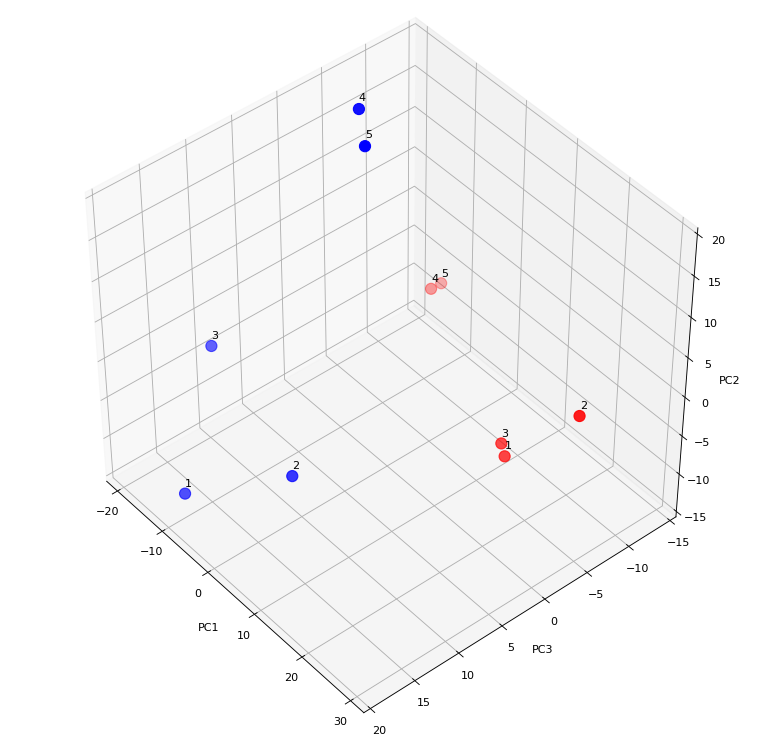

In [110]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pylab

fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(projection='3d')


col = np.where(cleaned['AfterProbiotic'],'r', 'b')
ax.scatter(xs=pcaDF['PC1'], ys=pcaDF['PC3'], zs=pcaDF['PC2'], c=col, s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC3')
ax.set_zlabel('PC2')
ax.set_zlim(-15, 20)

# invert y axis
ax.set_ylim(20, -15)

# set view angle
ax.view_init(elev=45., azim=320)


# label samples

xs=pcaDF['PC1']
ys=pcaDF['PC3']
zs=pcaDF['PC2']

for i in range(10):
    label = i // 2 + 1
    ax.text(xs[i], ys[i], zs[i] + 1, label)



In [111]:
components

array([[ -6.81662432,  -9.77205314,  19.50933244],
       [ 19.55277035,  -5.79244066,  -2.62934353],
       [  5.13658608,  -5.05340903,  13.62062249],
       [ 29.1958092 ,   2.63646043,  -5.36243183],
       [-18.93493767,  -3.08740169,   9.97873044],
       [ 17.39379896,  -5.83392132,  -3.49385473],
       [ -9.11163185,  23.42110684,  -1.94064484],
       [-15.02286122,  -8.53543318, -13.6369301 ],
       [ -3.33052858,  23.13890834,   0.56653394],
       [-18.06238095, -11.12181659, -16.61201429]])

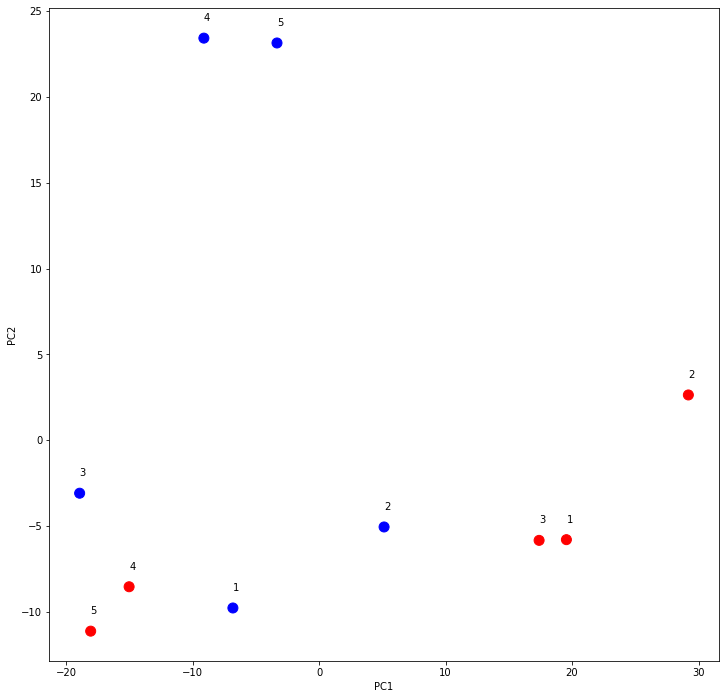

In [112]:
plt.figure(figsize=(12,12))
plt.scatter(components[:,0],components[:,1],c=col, s=100)
plt.xlabel('PC1')
plt.ylabel('PC2')
for i in range(10):
    label = i // 2 + 1
    plt.text(xs[i], zs[i] + 1, label)

## **Mann-Whitney U-Test**##

In [113]:
X_before = X.iloc[np.arange(0, 9, 2), :]
X_after = X.iloc[np.arange(1, 10, 2), :]
X_before.reset_index(inplace=True, drop=True)
X_after.reset_index(inplace=True, drop=True)
X_before.shape, X_after.shape

((5, 823), (5, 823))

In [114]:
X_before[0], X_after[0]

(0   -1.447063
 1   -0.690061
 2   -0.739138
 3    1.226585
 4    0.066149
 Name: 0, dtype: float64, 0    1.619466
 1   -0.564466
 2    1.279620
 3   -0.882412
 4    0.131321
 Name: 0, dtype: float64)

In [115]:
import scipy

mannwhitney = pd.DataFrame(columns=['U-test', 'p-value'])

# For each biochemical, perform the Mann-Whitney U test on the two classes: before and after probiotic. 
# Store values in mannwhitney
for biochem in range(823):
  if X_before[biochem].equals(X_after[biochem]):
    mannwhitney = mannwhitney.append({'U-test' : None, 'p-value' : None}, ignore_index=True)
    continue
  result = scipy.stats.mannwhitneyu(X_before[biochem], X_after[biochem], use_continuity=True)
  mannwhitney = mannwhitney.append({'U-test' : result.statistic, 'p-value' : result.pvalue}, ignore_index=True)
mannwhitney

,U-test,p-value
0,7.0,0.148135
1,12.0,0.500000
2,11.0,0.417266
3,7.0,0.132603
4,8.0,0.173261
...,...,...
818,6.0,0.105038
819,9.0,0.265435
820,12.0,0.500000
821,0.0,0.006093


In [116]:
# print the 10 biochemicals with lowest U-test scores
mannwhitney.nsmallest(10, columns='U-test')

,U-test,p-value
44,0.0,0.006093
86,0.0,0.006093
164,0.0,0.006093
182,0.0,0.006093
193,0.0,0.006093
223,0.0,0.006093
235,0.0,0.005580
271,0.0,0.006093
286,0.0,0.006093
344,0.0,0.006093
